In [1]:
import gym

import tensorflow as tf
from tensorflow import keras
print(tf.test.gpu_device_name())

import cv2

import numpy as np
from collections import deque

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
env_name = "CarRacing-v0"
env = gym.make(env_name)

env.seed(42)
np.random.seed(42)

C:\Users\antol\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, inputs):
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2GRAY)
        inputs = inputs.astype(float)
        inputs /= 255.0
        inputs = np.expand_dims(inputs, axis=-1)
        return inputs

In [4]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def render_policy_net(env, model, action_space, seed=42):
        frames = []
        env.seed(seed)
        np.random.seed(seed)
        obs = env.reset()
        negative_reward_counter=0
        for step in range(1000):
            frames.append(env.render(mode="rgb_array"))
            action_probas = model(obs[np.newaxis])
            print('action_probas', action_probas)
            p=tf.squeeze(action_probas).numpy()
            p /= np.sum(p)
            action = np.random.choice(range(5), p=p)
            print('action', action)
            obs, reward, done, info = env.step(action_space[action])
            if reward < 0:
                negative_reward_counter +=1
            else :
                negative_reward_counter = 0
            if done or negative_reward_counter > 75 :
                break
        env.close()
        return frames

# DQN Agent

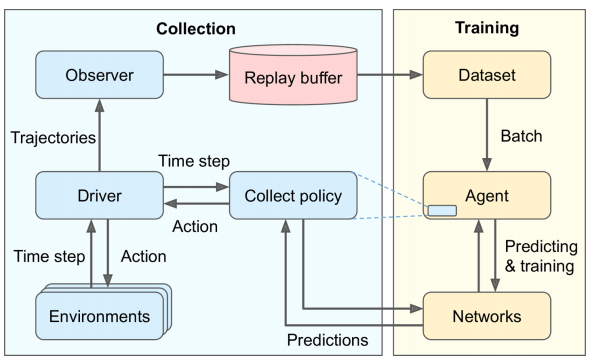

In [5]:
class DQNAgent:
    def __init__(self,
        env,
        action_space = [[-1,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]],
        replay_memory = deque(maxlen=2000),
        n_frame_stack = 4,
        limit = 75,
        discount_rate = 0.99,
        batch_size = 32,
        optimizer = keras.optimizers.Adam(lr=1e-2),
        n_episodes_per_update = 2,
        loss_fn = keras.losses.categorical_crossentropy
    ):
        self.env             = env
        self.action_space    = action_space
        self.n_actions       = len(action_space)
        self.replay_memory   = replay_memory
        self.n_frame_stack   = n_frame_stack
        self.limit           = limit
        self.discount_rate   = discount_rate
        self.batch_size      = batch_size
        self.optimizer       = optimizer
        self.model           = self.build_model()
        self.n_episodes_per_update = n_episodes_per_update
        self.loss_fn = loss_fn

    def build_model(self):
        model = keras.models.Sequential([
            ####### concatenate x images#######
        keras.layers.Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(96, 96, 1)), 
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=12, kernel_size=(4, 4), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(self.n_actions, activation ='softmax'])
        
        return model

    def play_one_step(self, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, info = self.env.step(self.action_space[action])
        self.replay_memory.append((state, action, reward, next_state, done))
        return next_state, reward, done, info
            

    def training_step(self):
        print('AO')
        experiences = self.sample_experiences()
        print("A")
        states, actions, rewards, next_states, dones = experiences
        next_Q_values = self.model.predict(next_states)
        print('B')
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = (rewards + (1 - dones) * self.discount_rate * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)
        print('C')
        mask = tf.one_hot(actions, self.n_actions)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            print('D')
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        print('E')
        grads = tape.gradient(loss, self.model.trainable_variables)
        print('F')
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        print('G')
        

    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
        return states, actions, rewards, next_states, dones
    
    
    def epsilon_greedy_policy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            Q_values = self.model.predict(state[np.newaxis])
            return np.argmax(Q_values[0])
    

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [6]:
n_steps = [] 
best_score = 0

mean_rewards = []
all_mean_losses = []

w_env = ObservationWrapper(env)
agent = DQNAgent(w_env)

#agent.load('models/DQN')

for episode in range(500):
    obs = agent.env.reset()
    negative_reward_counter = 0
    for step in range(1000):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = agent.play_one_step(obs, epsilon)
        if reward < 0 :
            negative_reward_counter += 1
        else :
            negative_reward_counter = 0
        if done or negative_reward_counter > agent.limit :
            break
    n_steps.append(step)
    if step > best_score:
        best_weights = agent.model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        agent.training_step()
    
    agent.save('models/DQN')


Track generation: 1208..1514 -> 306-tiles track
Episode: 0, Steps: 114, eps: 1.000Track generation: 1203..1508 -> 305-tiles track
Episode: 1, Steps: 126, eps: 0.998Track generation: 1127..1413 -> 286-tiles track
Episode: 2, Steps: 130, eps: 0.996Track generation: 1237..1550 -> 313-tiles track
Episode: 3, Steps: 134, eps: 0.994Track generation: 1129..1416 -> 287-tiles track
Episode: 4, Steps: 121, eps: 0.992Track generation: 1177..1475 -> 298-tiles track
Episode: 5, Steps: 119, eps: 0.990Track generation: 1048..1318 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1236..1549 -> 313-tiles track
Episode: 6, Steps: 113, eps: 0.988Track generation: 1243..1558 -> 315-tiles track
Episode: 7, Steps: 147, eps: 0.986Track generation: 1131..1418 -> 287-tiles track
Episode: 8, Steps: 105, eps: 0.984Track generation: 1157..1451 -> 294-tiles track
Episode: 9, Steps: 228, eps: 0.982Track generation: 1147..1438 -> 291-tiles track
Epis

Episode: 83, Steps: 77, eps: 0.834AO
A
B
C
D
E
F
G
Track generation: 1232..1552 -> 320-tiles track
Episode: 84, Steps: 77, eps: 0.832AO
A
B
C
D
E
F
G
Track generation: 1142..1432 -> 290-tiles track
Episode: 85, Steps: 143, eps: 0.830AO
A
B
C
D
E
F
G
Track generation: 1199..1503 -> 304-tiles track
Episode: 86, Steps: 77, eps: 0.828AO
A
B
C
D
E
F
G
Track generation: 978..1232 -> 254-tiles track
Episode: 87, Steps: 142, eps: 0.826AO
A
B
C
D
E
F
G
Track generation: 1115..1398 -> 283-tiles track
Episode: 88, Steps: 77, eps: 0.824AO
A
B
C
D
E
F
G
Track generation: 1185..1485 -> 300-tiles track
Episode: 89, Steps: 113, eps: 0.822AO
A
B
C
D
E
F
G
Track generation: 1184..1484 -> 300-tiles track
Episode: 90, Steps: 77, eps: 0.820AO
A
B
C
D
E
F
G
Track generation: 1167..1463 -> 296-tiles track
Episode: 91, Steps: 136, eps: 0.818AO
A
B
C
D
E
F
G
Track generation: 1172..1469 -> 297-tiles track
Episode: 92, Steps: 77, eps: 0.816AO
A
B
C
D
E
F
G
Track generation: 1209..1515 -> 306-tiles track
Episode

Episode: 158, Steps: 141, eps: 0.684AO
A
B
C
D
E
F
G
Track generation: 1136..1424 -> 288-tiles track
Episode: 159, Steps: 77, eps: 0.682AO
A
B
C
D
E
F
G
Track generation: 1056..1324 -> 268-tiles track
Episode: 160, Steps: 151, eps: 0.680AO
A
B
C
D
E
F
G
Track generation: 1135..1423 -> 288-tiles track
Episode: 161, Steps: 77, eps: 0.678AO
A
B
C
D
E
F
G
Track generation: 1047..1314 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1232..1544 -> 312-tiles track
Episode: 162, Steps: 77, eps: 0.676AO
A
B
C
D
E
F
G
Track generation: 1174..1471 -> 297-tiles track
Episode: 163, Steps: 77, eps: 0.674AO
A
B
C
D
E
F
G
Track generation: 1152..1444 -> 292-tiles track
Episode: 164, Steps: 120, eps: 0.672AO
A
B
C
D
E
F
G
Track generation: 1127..1412 -> 285-tiles track
Episode: 165, Steps: 77, eps: 0.670AO
A
B
C
D
E
F
G
Track generation: 1267..1596 -> 329-tiles track
Episode: 166, Steps: 139, eps: 0.668AO
A
B
C
D
E
F
G
Track generation

MemoryError: 

In [7]:
w_env.close()

Best score is 227


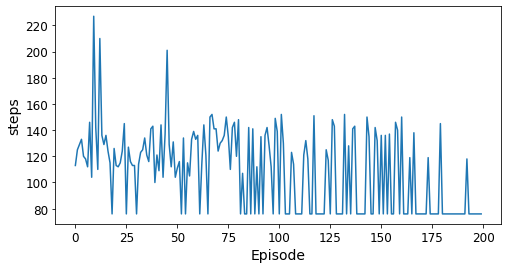

In [10]:
print('Best score is ' + str(best_score))
plt.figure(figsize=(8, 4))
plt.plot(n_steps)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("steps", fontsize=14)
plt.show()

In [ ]:
model.set_weights(best_weights)

def final_policy(state):
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])